In [1]:
from __future__ import division, print_function # python3 compatibilty
import pymc3 as pm
import numpy
import pandas as pd
import numpy as np                  # import numpy
from time import time               # use for timing functions
import matplotlib.gridspec as gridspec
from scipy import stats
#from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib.pyplot as plt
import arviz as az

rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.7
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'sans-serif'

# functions for plotting posteriors
import scipy
import corner
from scipy.stats import gaussian_kde
import os

In [2]:
#read the data
os.chdir('/Users/krishna/Documents/phd_work/SNe_data_analy/checks')

df = pd.read_csv('data_sbf_new.csv')
SN_sbf = df['SN_name'].to_numpy()
host = df['host'].to_numpy()
mu_sbf = df['mu_SBF'].to_numpy()
e_mu = df['e_mu'].to_numpy()
bmax = df['Bmax'].to_numpy()
ebmax = df['eBmax'].to_numpy()
vmax = df['Vmax'].to_numpy()
evmax = df['eVmax'].to_numpy()
st = df['stretch'].to_numpy()
est = df['err_stretch'].to_numpy()
color = df['color'].to_numpy()
ecolor = df ['e_color'].to_numpy()           #np.sqrt(eBmax**2 + eVmax**2)
log_M = df['log_Mass'].to_numpy()
e_logM = df['e_logMass'].to_numpy()
print(np.median(log_M))
#display(df)
print(len(SN_sbf))

#Lowzhflow_maxmodel_st
dff = pd.read_csv('data_lowz_HM.csv')
#df_cos = pd.read_csv('data_lowz_HM.csv')
df_cos = dff.loc[(dff['redshift'] > 0.02) & (dff['redshift'] < 0.15)]
SN_name = df_cos['SN_name'].to_numpy()
Bmax = df_cos['Bmax'].to_numpy()
eBmax = df_cos['eBmax'].to_numpy()
Vmax = df_cos['Vmax'].to_numpy()
eVmax = df_cos['eVmax'].to_numpy()
s = df_cos['stretch'].to_numpy()
es = df_cos['err_stretch'].to_numpy()
ebv = df_cos['color'].to_numpy()
eEBV = df_cos['e_color'].to_numpy()           #eEBV = np.sqrt(eBmax**2 + eVmax**2)
logM = df_cos['log_Mass'].to_numpy()
elogM = df_cos['e_logMass'].to_numpy()
z = df_cos['redshift'].to_numpy()

print(len(SN_name))


10.9315
26
96


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ext, sigma_SN, H0, alpha, R, P1, P0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:53<00:00, 299.17draws/s]


Time taken to run 'PyMC3' is 61.63683795928955 seconds
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
P0       -19.256  0.078 -19.408  -19.114      0.001    0.001    3257.0   
P1        -1.045  0.115  -1.254   -0.821      0.001    0.001    5969.0   
R          2.005  0.166   1.686    2.311      0.002    0.001    6830.0   
alpha     -0.033  0.039  -0.108    0.039      0.000    0.000    6352.0   
H0        68.628  2.385  64.218   73.085      0.040    0.028    3607.0   
sigma_SN   0.299  0.064   0.185    0.419      0.001    0.001    5660.0   
ext        0.149  0.016   0.119    0.180      0.000    0.000    6645.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
P0        3257.0    3309.0    3728.0    1.0  
P1        5969.0    5969.0    5773.0    1.0  
R         6830.0    6817.0    5840.0    1.0  
alpha     4806.0    6375.0    5309.0    1.0  
H0        3579.0    3696.0    3750.0    1.0  
sigma_SN  5474.0    5794.0    5163.0    1.0  
ext       6554.0    6702.0    

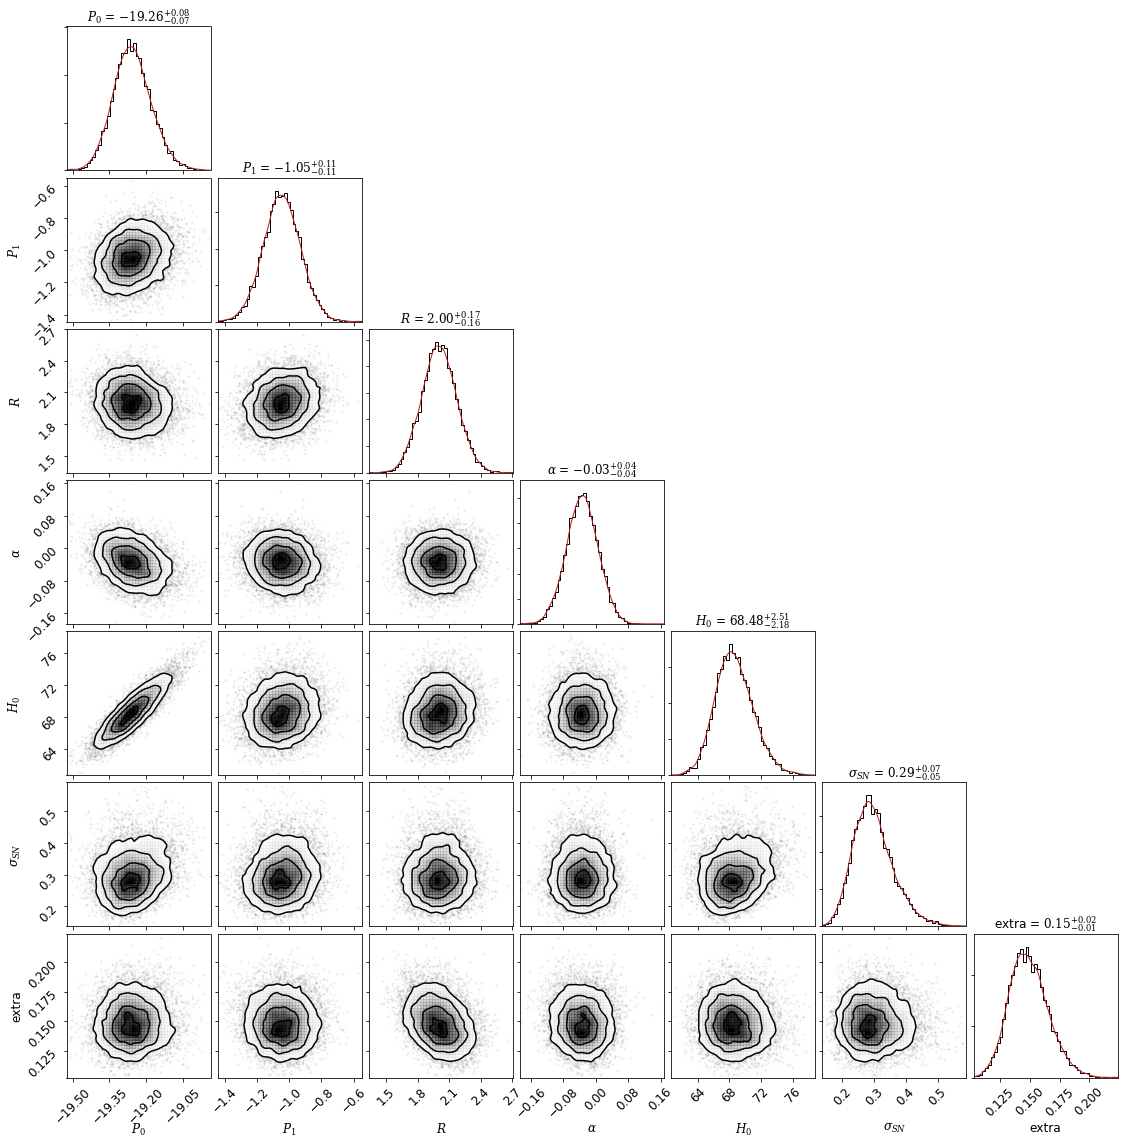

In [39]:
dirc = '/Users/krishna/Documents/phd_work/SNe_data_analy/checks/Hierchichal_analysis/figs/'
with pm.Model() as Hierarchical:
    P_0 = pm.Uniform('P0', lower = -30, upper = 30)
    P_1 = pm.Uniform('P1', lower = -5, upper = 5)
    R = pm.Uniform('R', lower = 0, upper = 15)
    alpha = pm.Uniform('alpha', lower = -2, upper = 2)    #step correction
    H0 = pm.Uniform('H0', lower = 60, upper = 80)
    sigma_SN = pm.HalfCauchy('sigma_SN', 5)
    ext = pm.HalfCauchy('ext', 5)
    
    c = 299792.458
    q0 = -0.55
    j0 = 1
    
    tm = 11   # value of M_step
    
    ms_calib = []
    for i in range(len (bmax)):
        if log_M[i] > tm:
            ms_calib.append(0)
        else:
            ms_calib.append(alpha)
    
    ms_cosmo = []
    for i in range(len (Bmax)):
        if logM[i] > tm:
            ms_cosmo.append(0)
        else:
            ms_cosmo.append(alpha)
    
    
    mu0 = P_0 + P_1*(st-1) + R*(color) + ms_calib + mu_sbf
    
    mu1 = P_0 + P_1*(s-1) + R*(ebv) + ms_cosmo + 5*np.log10((c*z/H0)*(1 + 1/2*(1- q0)*z - 1/6*(1- q0 - 3*q0**2 + j0)*z**2)) + 25
    
    
    sigma0 = np.sqrt(ebmax ** 2 + sigma_SN**2 + e_mu**2 + (P_1*est)**2 +
                    R**2*(ebmax**2 + evmax**2) - 2*R*ebmax**2 + 0.4*e_mu**2)
    
    sigma1 = np.sqrt(eBmax ** 2 + ext**2 + (P_1*es)**2 +
                    R**2*(eEBV**2) - 2*R*eBmax**2)
    
    #m_B = pm.Normal('m_B', mu=y_est, sd = sigma, observed=mb)
    results0 = pm.Normal('results0', mu0, sigma0, observed = bmax)
    results1 = pm.Normal('results1', mu1, sigma1, observed = Bmax)
    # This line is constructing the likelihood for me taking mu, model, and sigma
    
    
    Nsamples = 2000  # final number of samples
    Ntune = 2000 # number of tuning samples

    # perform sampling
    t0 = time()
    trace = pm.sample(Nsamples, tune=Ntune, discard_tuned_samples=True, cores=4,target_accept=0.9);  # perform sampling
    t1 = time()
    timepymc3 = (t1-t0)
    print("Time taken to run 'PyMC3' is {} seconds".format(timepymc3))
    plt.rcParams.update({'font.size': 12})
    #pm.traceplot(trace)
    print(pm.summary(trace))
#------------------------------------------------------------------------
#Function to plot corner plots
    
def plotposts(samples):    
    fig = corner.corner(samples, bins = 50, labels=[r'$P_0$', r'$P_1$', r'$R$', r'$\alpha$', r'$H_0$', r'$\sigma_{SN}$', r'extra'], 
                        color = 'black',
                        show_titles=True,
                        hist_kwargs={'density': True}, smooth = True, title_kwargs={"fontsize": 12},
                        label_kwargs={"fontsize": 12})


        # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 8, 16, 24, 32, 40, 48], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick', lw = 1)
    fig = plt.gcf() # to get the current figure...
    fig.savefig(dirc+'SBF_stepHM_11.pdf',dpi = 500, bbox_inches='tight', pad_inches=0.2)
    
samples_pymc3 = np.vstack((trace['P0'], trace['P1'], trace['R'], trace['alpha'], trace['H0'], trace['sigma_SN'], trace['ext'])).T
plotposts(samples_pymc3)